In [2]:
import numpy as np
from scipy.stats import linregress
from functools import partial
from itertools import product

import pennylane as qml
from pennylane import numpy as pnp

from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import fold_global, fold_gates_at_random, fold_gates_from_right
from mitiq.zne.inference import RichardsonFactory, AdaExpFactory

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeAuckland, FakeKolkataV2
import qiskit

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Pennylane + qiskit backend

In [2]:
def first_nonzero_index(lst):
    for i, element in enumerate(lst):
        if element != 0:
            return i
    return None  # If no nonzero elements are found

def num2Pauli(x, i):
    if x == 1:
        return qml.PauliX(i)
    elif x == 2:
        return qml.PauliY(i)
    elif x == 3:
        return qml.PauliZ(i)

def randomPaulis(n, num):
    np.random.seed(42)
    coeffs = np.random.normal(size=num)

    paulis = list(product(range(4), repeat=n))[1:]
    items = np.random.choice(len(paulis), size=num, replace=False)
    items = [paulis[x] for x in items]

    obs = []
    for each in items:
        idx = first_nonzero_index(each)
        expr = num2Pauli(each[idx], idx)
        for i in range(idx+1, n):
            if each[i] != 0:
                expr = expr @ num2Pauli(each[i], i)
        obs.append(expr)
    
    return qml.Hamiltonian(coeffs, obs)

def XXZ(n, J):
    coeffs = []
    obs1 = []
    for i in range(n):
        obs1.append(qml.PauliZ(i))
        coeffs.append(-J)

    obs2 = []
    for i in range(n-1):
        obs2.append(qml.PauliX(i) @ qml.PauliX(i+1))
        obs2.append(qml.PauliY(i) @ qml.PauliY(i+1))
        coeffs.extend([-1, -1])

        obs2.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
        coeffs.append(-J)
    
    obs = obs1 + obs2
    return qml.Hamiltonian(coeffs, obs)

In [3]:
def HEA_ansatz(params, wires, depth):
    for l in range(depth):
        for i in range(wires):
            qml.RY(params[2 * wires * l + i], wires=i)
            qml.RZ(params[2 * wires * l + wires + i], wires=i)
        for i in range(0, wires-1, 2):
            qml.CNOT(wires = [i, i+1])
        for i in range(1, wires-1, 2):
            qml.CNOT(wires = [i, i+1])

# Simulation with $n=2$

## Noiseless simulation

In [26]:
dev = qml.device("default.qubit", wires=2)
print(dev)

@qml.qnode(dev)
def Hexpect(params, wires, depth, h):
    HEA_ansatz(params, wires, depth)
    return qml.expval(h)

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.32.0
Author: Xanadu Inc.
Wires: 2
Shots: None


In [7]:
# Above GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -10

depth = 4

stepsize = 0.001
max_iterations = 200
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist = []
params_hist = np.zeros((max_iterations, 2*qubits*depth))
for step in range(max_iterations):
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect, wires=qubits, depth=depth, h=h), params)
    eps_hist.append(eps) # save current epsilon
    params_hist[step] = params
    if not step or (step+1)%20 == 0:
        print(step, eps)
    params = new_params # update parameter
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s.npy'%O0, eps_hist)
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAparamsHistXXZ_n2L4Tgt%s.npy'%O0, params_hist)

0 11.891171103731239
19 0.9801409914287831
39 0.2371103334310085
59 0.07166197499147842
79 0.02293911793521808
99 0.007473063866338947
119 0.002448344755766385
139 0.0008036113339304762
159 0.0002639256445533533
179 8.669681668393991e-05
199 2.8480851231194038e-05


In [27]:
# At GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -12
depth = 4

stepsize = 0.001
max_iterations = 200
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist = []
params_hist = np.zeros((max_iterations, 2*qubits*depth))
for step in range(max_iterations):
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect, wires=qubits, depth=depth, h=h), params)
    eps_hist.append(eps) # save current epsilon
    params_hist[step] = params
    if not step or (step+1)%20 == 0:
        print(step, eps)
    params = new_params # update parameter
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s.npy'%O0, eps_hist)
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAparamsHistXXZ_n2L4Tgt%s.npy'%O0, params_hist)

0 13.891171103731239
19 1.7748827561932217
39 0.913391144873053
59 0.6293128757115287
79 0.48583788799078675
99 0.3985575833339112
119 0.3395394172826691
139 0.29680216164554807
159 0.2643306561229881
179 0.23876457717559063
199 0.21807518853136543
[[ 7.39066962 11.28100341 11.20330556 ... 10.68553227  9.74201465
   0.46073726]
 [ 7.35576079 11.34731753 11.20248904 ... 10.62313723  9.74400567
   0.46073726]
 [ 7.32483727 11.41466791 11.20254908 ... 10.56176792  9.74541279
   0.46073726]
 ...
 [ 7.18209492 11.88211942 11.2090272  ... 10.21571391  9.74251873
   0.46073726]
 [ 7.18202873 11.88224101 11.20905961 ... 10.21563426  9.74251471
   0.46073726]
 [ 7.18196291 11.88236163 11.2090919  ... 10.21555517  9.74251072
   0.46073726]]


In [14]:
# Below GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -15
Omin = -12
depth = 4

stepsize = 0.001
max_iterations = 200
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist = []
params_hist = np.zeros((max_iterations, 2*qubits*depth))
for step in range(max_iterations):
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect, wires=qubits, depth=depth, h=h), params)
    eps_hist.append(eps) # save current epsilon
    params_hist[step] = params
    if not step or (step+1)%20 == 0:
        print(step, eps + O0 - Omin)
    params = new_params # update parameter
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s.npy'%O0, eps_hist)
np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAparamsHistXXZ_n2L4Tgt%s.npy'%O0, params_hist)

0 13.891171103731239
19 0.7020779065767666
39 0.164655362058447
59 0.058467117335691654
79 0.025552876230660715
99 0.012692771606353404
119 0.006866221608444079
139 0.003935231181628751
159 0.0023443484263427905
179 0.0014326863666269674
199 0.000890251998891145


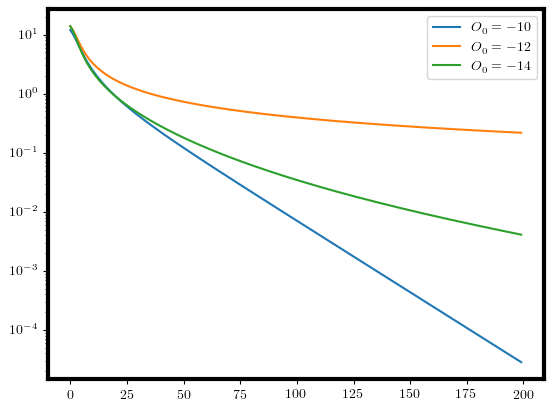

In [16]:
O0list = [-10, -12, -14]
Omin = -12
Rlist = [min(x - Omin, 0) for x in O0list]

for i, O0 in enumerate(O0list):
    eps = np.load('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s.npy'%O0)
    plt.plot(eps + Rlist[i], label=r'$O_0=%s$'%O0)

plt.legend()
plt.yscale('log')

## Simulation with noise model

In [51]:
backend = FakeAuckland()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['cx', 'measure', 'id', 'reset', 'sx', 'x']>

In [52]:
dev_aer_noise = qml.device("qiskit.aer", wires=2, optimization_level=0, noise_model=noise_model,
                           shots=1000)

## Training with noise model

In [110]:
dev_aer_noise = qml.device("qiskit.aer", wires=2, optimization_level=0, 
                           shots=1000, noise_model=noise_model)
print(dev_aer_noise)

Qiskit PennyLane plugin
Short name: qiskit.aer
Package: pennylane_qiskit
Plugin version: 0.32.0
Author: Xanadu
Wires: 2
Shots: 1000


### Without error mitigation

In [68]:
# Above GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -10
depth = 4

stepsize = 0.001
max_iterations = 50
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def Hexpect(params, wires, depth, h):
    HEA_ansatz(params, wires, depth)
    return qml.expval(h)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist_noise = []
for step in range(max_iterations):
    Hexpect_noisy = qml.QNode(Hexpect, dev_aer_noise)
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect_noisy, wires=qubits, depth=depth, h=h), params)
    eps_hist_noise.append(eps) # save current epsilon
    if not step or (step+1)%10 == 0:
        print(step, eps)
    params = new_params # update parameter

np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s_shot1000NoiseSimu'%O0, eps_hist_noise)

0 11.32
9 3.3920000000000003
19 1.5500000000000007
29 0.7739999999999991
39 0.7900000000000009
49 0.20999999999999908


In [69]:
# At GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -12
depth = 4

stepsize = 0.001
max_iterations = 50
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def Hexpect(params, wires, depth, h):
    HEA_ansatz(params, wires, depth)
    return qml.expval(h)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist_noise = []
for step in range(max_iterations):
    Hexpect_noisy = qml.QNode(Hexpect, dev_aer_noise)
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect_noisy, wires=qubits, depth=depth, h=h), params)
    eps_hist_noise.append(eps) # save current epsilon
    if not step or (step+1)%10 == 0:
        print(step, eps)
    params = new_params # update parameter

np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s_shot1000NoiseSimu'%O0, eps_hist_noise)

0 13.546
9 4.8260000000000005
19 2.6419999999999995
29 1.982000000000001
39 1.6579999999999995
49 1.572000000000001


In [70]:
# Below GS
qubits = 2
J = 4
h = XXZ(qubits, J)
O0 = -14
depth = 4

stepsize = 0.001
max_iterations = 50
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

pnp.random.seed(20)
params = pnp.random.uniform(0, 4*np.pi, 2*qubits*depth, requires_grad=True)

def Hexpect(params, wires, depth, h):
    HEA_ansatz(params, wires, depth)
    return qml.expval(h)

def step_and_cost(opt, O0, objective_fn, *args, grad_fn=None, **kwargs):
    g, forward = opt.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
    grad_eps = g[0]
    grad_loss = (forward - O0)*grad_eps

    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], forward - O0

eps_hist_noise = []
for step in range(max_iterations):
    Hexpect_noisy = qml.QNode(Hexpect, dev_aer_noise)
    new_params, eps = step_and_cost(opt, O0, partial(Hexpect_noisy, wires=qubits, depth=depth, h=h), params)
    eps_hist_noise.append(eps) # save current epsilon
    if not step or (step+1)%10 == 0:
        print(step, eps)
    params = new_params # update parameter

np.save('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s_shot1000NoiseSimu'%O0, eps_hist_noise)

0 15.55
9 5.454000000000001
19 3.8519999999999985
29 3.523999999999999
39 3.1899999999999995
49 2.991999999999999


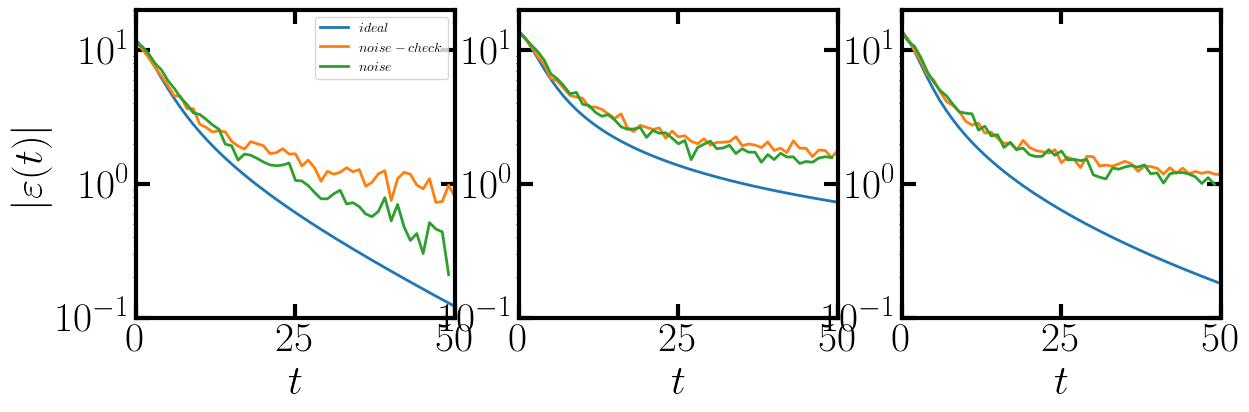

In [71]:
# plot
O0list = [-10, -12, -14]
Omin = -12
Rlist = [min(x-Omin, 0) for x in O0list]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for i, O0 in enumerate(O0list):
    eps_ideal = np.load('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s.npy'%O0)
    eps_noise_check = np.load('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s_shot1000NoiseCheck.npy'%O0)
    eps_noise = np.load('data/Training/qubits/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt%s_shot1000NoiseSimu.npy'%O0)

    axs[i].plot(eps_ideal + Rlist[i], lw=2, label=r'$ideal$')
    axs[i].plot(eps_noise_check + Rlist[i], lw=2, label=r'$noise-check$')
    axs[i].plot(eps_noise + Rlist[i], lw=2, label=r'$noise$')

    axs[i].set_yscale('log')
    axs[i].set_ylim(0.1, 20)
    axs[i].set_xlim(0, 50)

    axs[i].set_xlabel(r'$t$', fontsize=30)
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
axs[0].legend()
axs[0].set_ylabel(r'$|\varepsilon(t)|$', fontsize=30)

#plt.savefig('figures/qubits/HEArandP_n2L8_nairobiSimu.pdf', bbox_inches='tight')
plt.show()
plt.close()

## plot

0.028180364276688057 0.006561161514004675
0.04365472857359309 0.010788866451483064
0.05136834080962116 0.005407507563258419


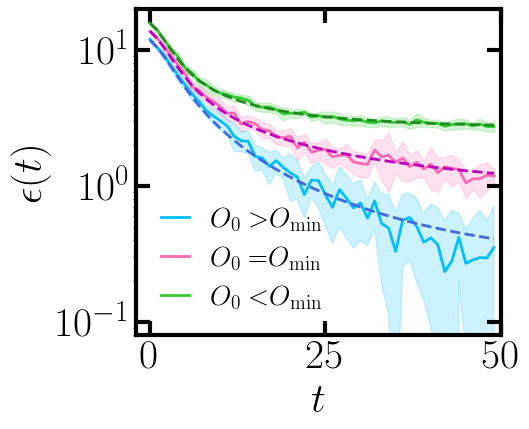

In [153]:
O0s = [-10, -12, -14]
eps_list = []
eps_noise_list = []
ps = []
for O0 in O0s:
    eps_list.append(np.load(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}.npy'))
    eps_noise_list.append(np.genfromtxt(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}Kolkata.csv', 
                            delimiter=','))
    p = np.sum((eps_list[-1][10:50] - eps_noise_list[-1][:,10:]) * (eps_list[-1][10:50] + O0), axis=1) \
            / np.sum((eps_list[-1][10:50] + O0)**2)
    ps.append(p)
    print(np.mean(p), np.std(p))


fig, ax = plt.subplots(figsize=(6, 5))
cl = ['deepskyblue', 'hotpink', 'limegreen']
cl2 = ['royalblue', 'm', 'forestgreen']
signs = ['>', '=', '<']
for i in range(3):
    p = np.mean(ps[i])
    if i < 2:
        R = -p * O0s[i]
    else:
        R = (1-p) * O0s[1] - O0s[i]
    eps_n = eps_noise_list[i]
    vareps_n = eps_n - R
    ax.plot(np.mean(eps_n, axis=0), c=cl[i], lw=2, label=fr'$O_0 {signs[i]}$'+ r'$O_{\rm min}$', zorder=5)
    ax.fill_between(np.arange(50), np.mean(eps_n, axis=0) - np.std(eps_n, axis=0), 
                 np.mean(eps_n, axis=0) + np.std(eps_n, axis=0), color=cl[i], alpha=0.2)
    ax.plot((1-p) * eps_list[i][:50] - p * O0s[i], '--', c=cl2[i], lw=2, zorder=5)

ax.legend(fontsize=20, framealpha=0, handlelength=1)

ax.set_yscale('log')
ax.set_ylim(8e-2, 20)
ax.set_xlim(-2, 50)
ax.set_xticks([0, 25, 50])
ax.set_xlabel(r'$t$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on')

ax.set_ylabel(r'$\epsilon(t)$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

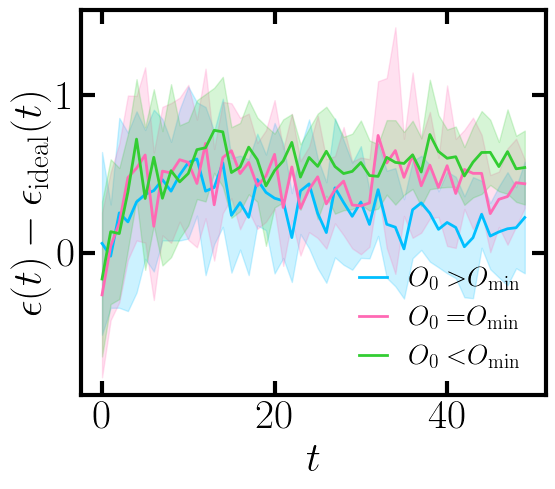

In [68]:
O0s = [-10, -12, -14]
eps_list = []
eps_noise_list = []
ps = []
for O0 in O0s:
    eps_list.append(np.load(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}.npy'))
    eps_noise_list.append(np.genfromtxt(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}Kolkata.csv', 
                            delimiter=','))

fig, ax = plt.subplots(figsize=(6, 5))
cl = ['deepskyblue', 'hotpink', 'limegreen']
signs = ['>', '=', '<']
for i in range(3):
    devs = eps_noise_list[i] - eps_list[i][:50]
    ax.plot(np.mean(devs, axis=0), c=cl[i], lw=2, label=fr'$O_0 {signs[i]}$'+ r'$O_{\rm min}$')
    ax.fill_between(np.arange(50), np.mean(devs, axis=0)-np.std(devs, axis=0), 
                    np.mean(devs, axis=0)+np.std(devs, axis=0), color=cl[i], alpha=0.2)

ax.legend(fontsize=20, framealpha=0, handlelength=1)
#ax.set_yscale('log')
ax.set_ylabel(r'$\epsilon(t)-\epsilon_{\rm ideal}(t)$')
ax.set_xlabel(r'$t$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on')


0.028180364276688057 0.006561161514004675
0.04365472857359309 0.010788866451483064
0.05136834080962116 0.005407507563258419


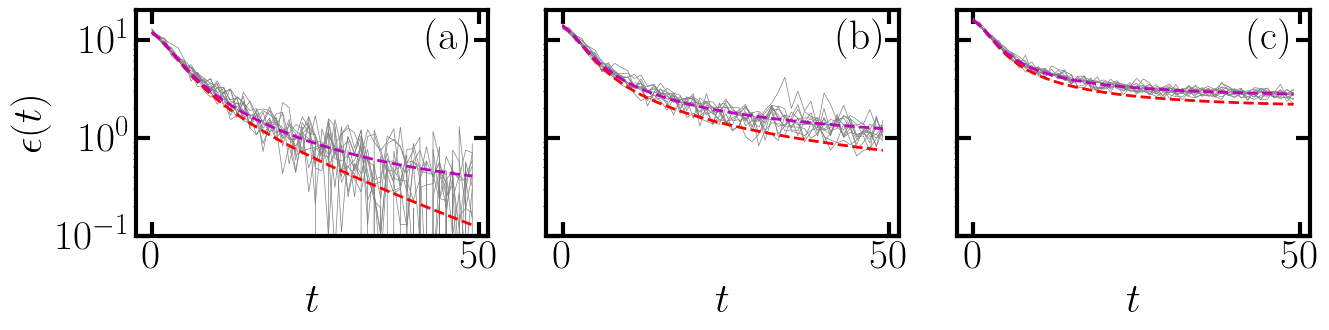

In [67]:
O0s = [-10, -12, -14]

eps_list = []
eps_noise_list = []
ps = []
for O0 in O0s:
    eps_list.append(np.load(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}.npy'))
    eps_noise_list.append(np.genfromtxt(f'data/Training/HEA/Heisenberg/n2/HEAepsHistXXZ_n2L4Tgt{O0}Kolkata.csv', 
                            delimiter=','))
    p = np.sum((eps_list[-1][10:50] - eps_noise_list[-1][:,10:]) * (eps_list[-1][10:50] + O0), axis=1) \
            / np.sum((eps_list[-1][10:50] + O0)**2)
    ps.append(p)
    print(np.mean(p), np.std(p))

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for i in range(3):
    axs[i].plot(eps_noise_list[i].T, c='grey', lw=0.5)
    axs[i].plot(eps_list[i][:50], '--', c='r', lw=2)
    p = np.mean(ps[i])
    axs[i].plot((1-p) * eps_list[i][:50] - p * O0s[i], '--', c='m', lw=2)

for i in range(3):
    axs[i].set_ylim(1e-1, 20)
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$t$', fontsize=30)
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
axs[0].set_ylabel(r'$\epsilon(t)$', fontsize=30)

axs[0].text(42, 8, r'$\rm (a)$', fontsize=30)
axs[1].text(42, 8, r'$\rm (b)$', fontsize=30)
axs[2].text(42, 8, r'$\rm (c)$', fontsize=30)
plt.tight_layout()

200 1.0210000000000004 0.4075647187870906
600 0.9468333333333332 0.23310816516515812
1000 1.0018 0.1831348137302136


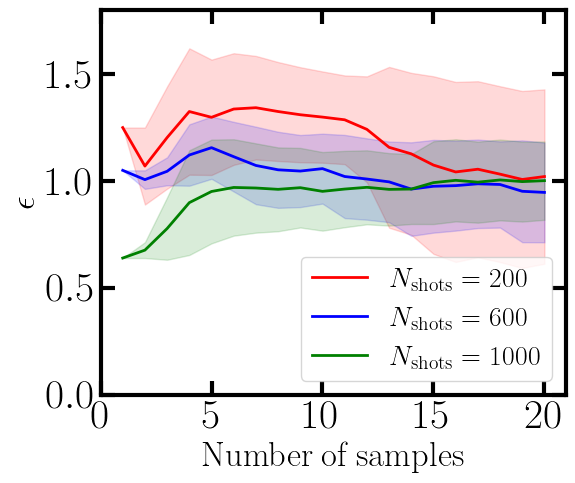

In [4]:
data = np.zeros((3, 20))
Ns = [200, 600, 1000]
for i in range(3):
    data[i] = np.load(f'data/Training/HEA/Heisenberg/n2/SherbrookeData_shot{Ns[i]}.npy')

fig, ax = plt.subplots(figsize=(6, 5))
cl = ['r', 'b', 'g']
for i in range(3):
    mean = np.array([np.mean(data[i,:k]) for k in range(1, 21)])
    std = np.array([np.std(data[i,:k]) for k in range(1, 21)])
    ax.errorbar(np.arange(1, 21), mean, fmt='-', c=cl[i], lw=2, label=r'$N_{\rm shots}=%d$'%Ns[i])
    ax.fill_between(np.arange(1, 21), mean-std, mean+std, color=cl[i], alpha=0.15)
    print(Ns[i], mean[-1], std[-1])
ax.legend(fontsize=20, )
ax.set_ylim(0, 1.8)
ax.set_xticks(np.arange(0, 21, 5))
ax.set_xlabel(r'$\rm Number\: of\: samples$')
ax.set_ylabel(r'$\epsilon$')
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)
